# Smart Budget Planner
Data Prepared by Raphael Lu and Jeel Faldu

In [1]:
import pandas as pd
import numpy as np
import json
import statistics
import matplotlib.pyplot as plt
import plotly.express as px


import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)  #diplays numbers in decimal v sci notation

## Introduction

The purpose of this project is to prepare data for a Smart Budget Planner Project. Specifically, we take a kaggle dataset of international customer credit card transactions from 01 October to 30 October 2024


## Data Loading and Pre-processing

### Historic Currency Conversion Rates

During data exploration, it was found that multiple customers made foreign transaction. The dictionary below was obtain with the use of Claude.

**Currency Conversion Rates**  
Source: HM Revenue & Customs (HMRC) - October 2024 Monthly Exchange Rates
Retrieved via: Claude AI (Anthropic) web search on November 9, 2025
Original source: https://www.trade-tariff.service.gov.uk/exchange_rates/view/2024-10
Date Range: October 1-31, 2024

In [2]:
conversion_to_usd = {
    'USA': 1.0,
    'UK': 0.757,        # 1 GBP = 1.32 USD → 1 USD = 0.757 GBP
    'Brazil': 0.182,    # BRL: 7.24 per GBP → 5.48 per USD
    'Japan': 0.00706,   # JPY: 187.4 per GBP → 141.8 per USD
    'Australia': 0.679, # AUD: 1.95 per GBP → 1.47 per USD
    'Nigeria': 0.00061, # NGN: 2165.7 per GBP → 1639 per USD
    'Germany': 0.842,   # EUR: 1.19 per GBP → 1.09 EUR per USD
    'Mexico': 0.0524,   # MXN: 25.21 per GBP → 19.08 per USD
    'Russia': 0.0109,   # RUB: 121.3 per GBP → 91.8 per USD
    'France': 0.842,    # EUR (same as Germany)
    'Canada': 0.736,    # CAD: 1.79 per GBP → 1.36 per USD
    'Singapore': 0.773  # SGD: 1.71 per GBP → 1.29 per USD
}

denom_dict = {
    'USD': 1.0,
    'GBP': 0.757,
    'BRL': 0.182,
    'JPY': 0.00706,
    'AUD': 0.679,
    'NGN': 0.00061,
    'EUR': 0.842,
    'MXN': 0.0524,
    'RUB': 0.0109,
    'CAD': 0.736,
    'SGD': 0.773
}

country_to_currency = {
    'USA': 'USD',
    'UK': 'GBP',
    'Brazil': 'BRL',
    'Japan': 'JPY',
    'Australia': 'AUD',
    'Nigeria': 'NGN',
    'Germany': 'EUR',
    'Mexico': 'MXN',
    'Russia': 'RUB',
    'France': 'EUR',
    'Canada': 'CAD',
    'Singapore': 'SGD'
}

### df Loading

In [3]:
df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                            "ismetsemedov/transactions",
                            "synthetic_fraud_data.csv")

Using Colab cache for faster access to the 'transactions' dataset.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 24 columns):
 #   Column               Dtype  
---  ------               -----  
 0   transaction_id       object 
 1   customer_id          object 
 2   card_number          int64  
 3   timestamp            object 
 4   merchant_category    object 
 5   merchant_type        object 
 6   merchant             object 
 7   amount               float64
 8   currency             object 
 9   country              object 
 10  city                 object 
 11  city_size            object 
 12  card_type            object 
 13  card_present         bool   
 14  device               object 
 15  channel              object 
 16  device_fingerprint   object 
 17  ip_address           object 
 18  distance_from_home   int64  
 19  high_risk_merchant   bool   
 20  transaction_hour     int64  
 21  weekend_transaction  bool   
 22  velocity_last_hour   object 
 23  is_fraud             bool   
dty

In [5]:
df.head(6)

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,0,False,0,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464+00:00,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,1,True,0,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,0,False,0,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,...,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,0,False,0,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063+00:00,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,1,False,0,False,"{'num_transactions': 218, 'total_amount': 4827...",True
5,TX_7fb62ea6,CUST_55630,6771346275824473,2024-09-30 00:00:03.050458+00:00,Education,online,Coursera,11.76,BRL,Brazil,...,Chrome,web,f79b73f19703d83fbfc2736f24cb108c,184.56.130.84,1,False,0,False,"{'num_transactions': 1130, 'total_amount': 695...",True


In [6]:
print('Unique Categories:', df['merchant_category'].unique())
print()
print('Unique Merchant Types (sub catagories):', df['merchant_type'].unique())
print()
print('Unique Countries:', df['country'].unique())
print()
print('Unique Currencies:', df['currency'].unique())

Unique Categories: ['Restaurant' 'Entertainment' 'Grocery' 'Gas' 'Healthcare' 'Education'
 'Travel' 'Retail']

Unique Merchant Types (sub catagories): ['fast_food' 'gaming' 'physical' 'major' 'medical' 'online' 'hotels'
 'pharmacy' 'premium' 'events' 'supplies' 'airlines' 'local' 'booking'
 'streaming' 'transport' 'casual']

Unique Countries: ['UK' 'Brazil' 'Japan' 'Australia' 'Nigeria' 'Germany' 'Mexico' 'Russia'
 'France' 'Canada' 'Singapore' 'USA']

Unique Currencies: ['GBP' 'BRL' 'JPY' 'AUD' 'NGN' 'EUR' 'MXN' 'RUB' 'CAD' 'SGD' 'USD']


### Drop Irrelevant Columns

In [7]:
# Drop Fraud Cases
df = df[df['is_fraud'] == False]

# Cols to drop
drop_cols = ['card_number', 'city_size', 'card_type', 'card_present',
             'device_fingerprint', 'ip_address',
             'high_risk_merchant','velocity_last_hour','device','is_fraud',
             'transaction_hour','city']

### Create Transactions df

In [8]:
df_transactions = df.copy().drop(drop_cols, axis=1)
df_transactions

,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,channel,distance_from_home,weekend_transaction
0,TX_a0ad2a2a,CUST_72886,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,mobile,0,False
2,TX_a9461c6d,CUST_10715,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,web,0,False
3,TX_7be21fc4,CUST_16193,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,mobile,0,False
6,TX_e0d7eb37,CUST_89147,2024-09-30 00:00:03.149440+00:00,Grocery,online,Instacart,2606.19,BRL,Brazil,mobile,0,False
7,TX_eb55c2be,CUST_10150,2024-09-30 00:00:06.295911+00:00,Travel,hotels,Westin,828.33,EUR,Germany,web,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7483761,TX_58a762fa,CUST_11344,2024-10-30 23:59:58.926575+00:00,Retail,online,AliExpress,887.32,SGD,Singapore,web,0,False
7483762,TX_dabcf671,CUST_38961,2024-10-30 23:59:58.950801+00:00,Grocery,physical,Kroger,356.06,EUR,France,web,0,False
7483763,TX_ab567eb4,CUST_75576,2024-10-30 23:59:58.972155+00:00,Grocery,physical,Kroger,391.96,SGD,Singapore,web,0,False
7483764,TX_5ae61846,CUST_82508,2024-10-30 23:59:58.996608+00:00,Retail,online,eBay,601.71,USD,USA,web,0,False


In [9]:
#### test switch 1 and 0 in distance from home
#df_transactions['distance_from_home'] = 1 - df_transactions['distance_from_home']

### Drop Duplicate Columns

In [10]:
df_transactions.drop_duplicates(subset=['customer_id', 'transaction_id'], inplace=True)

### Timestamp Processing

Data were collected from 30 Sept through 30 October. For calander month represensation, September transactions were dropped from the dataset.

In [11]:
df_transactions['timestamp'] = pd.to_datetime(df_transactions['timestamp'], format='mixed')

In [12]:
df_transactions['timestamp'].min(), df_transactions['timestamp'].max()

(Timestamp('2024-09-30 00:00:01.034820+0000', tz='UTC'),
 Timestamp('2024-10-30 23:59:59.101885+0000', tz='UTC'))

In [13]:
df_transactions['date_transact'] = df_transactions['timestamp'].dt.strftime('%d-%m-%Y')

In [14]:
df_transactions['date_transact'] = pd.to_datetime(df_transactions['date_transact'], dayfirst=True)
df_transactions = df_transactions[df_transactions['date_transact'].dt.month != 9].copy()

df_transactions['date_transact'] = df_transactions['date_transact'].dt.strftime('%Y-%m-%d')
df_transactions.drop('timestamp', axis = 1)
display(df_transactions.head(3))


,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,channel,distance_from_home,weekend_transaction,date_transact
240937,TX_26fcd971,CUST_82404,2024-10-01 00:00:00.771360+00:00,Grocery,physical,Kroger,146.82,AUD,Australia,mobile,0,False,2024-10-01
240938,TX_72acc22e,CUST_94778,2024-10-01 00:00:01.466583+00:00,Retail,physical,Target,2246.80,BRL,Brazil,web,0,False,2024-10-01
240939,TX_618e4c2e,CUST_67481,2024-10-01 00:00:02.210550+00:00,Retail,physical,Costco,1750.32,SGD,Singapore,mobile,0,False,2024-10-01


### Categories and Sub-categories

In [15]:
for cat in df_transactions['merchant_category'].unique():
  mask = df_transactions['merchant_category'] == cat
  print(f'Sub Categories in {cat}', df_transactions[mask]['merchant_type'].unique())
  print()

Sub Categories in Grocery ['physical' 'online']

Sub Categories in Retail ['physical' 'online']

Sub Categories in Restaurant ['fast_food' 'casual' 'premium']

Sub Categories in Gas ['local' 'major']

Sub Categories in Entertainment ['events' 'gaming' 'streaming']

Sub Categories in Healthcare ['medical' 'pharmacy']

Sub Categories in Education ['online' 'supplies']

Sub Categories in Travel ['transport' 'hotels' 'booking' 'airlines']



## Noted Data Irregularity

When looking a all transactions made in the USA, total October spending was distributed as
- count: 4869
- mean:      \$49,444.40
- std:      \$157,870.52
- min:         **\$145.89**
- 50%:        **\$8,632.44**
- max:     \$1,674,076.82

However, when looking at transactions made in the USA, with `'distance_from_home' == 0` (presumed US based shoppers), the total October spending was distributed as:
- count: 382
- mean:      \$506,713.52
- std:      \$157,870.52
- min:         **\$163,212.85**
- 50%:        **\$424,368.83**
- max:     \$1,674,076.82

Given that the STD is unchanged across both samples, it is assumed that these 382 cases, skew/obscure the data.

For the purpose of this project (and given that we are working with syntheic data), we assumed that these 382 select cases that do not reflect typical customer usage.

**Processing**: After accounting for currency conversions, users who spent a monthly today at or >75th%-tile were dropped from the dataset.

In [16]:
usa_transaction_mask = (df_transactions['country'] == 'USA')
home_usa_mask = (df_transactions['country'] == 'USA') & (df_transactions['distance_from_home'] == 0)

test_stats_1 = df_transactions[usa_transaction_mask].groupby('customer_id')['amount'].sum().describe()
test_stats_2 = df_transactions[home_usa_mask].groupby('customer_id')['amount'].sum().describe()

test_stats_1, test_stats_2

(count      4869.00
 mean      47865.89
 std      152900.71
 min         145.89
 25%        4675.58
 50%        8338.80
 75%       15291.47
 max     1612783.45
 Name: amount, dtype: float64,
 count       382.00
 mean     490639.46
 std      289666.24
 min      156997.27
 25%      290005.62
 50%      413465.74
 75%      572514.11
 max     1612783.45
 Name: amount, dtype: float64)

#### Similar patterns seen in Mexico and Canada data

In [17]:
mex_transaction_mask = (df_transactions['country'] == 'Mexico')
home_mex_mask = (df_transactions['country'] == 'Mexico') & (df_transactions['distance_from_home'] == 0)

test_stats_1 = df_transactions[mex_transaction_mask].groupby('customer_id')['amount'].sum().describe()
test_stats_2 = df_transactions[home_mex_mask].groupby('customer_id')['amount'].sum().describe()

print(test_stats_1,'\n' ,test_stats_2)

can_transaction_mask = (df_transactions['country'] == 'Canada')
home_can_mask = (df_transactions['country'] == 'Canada') & (df_transactions['distance_from_home'] == 0)

test_stats_3 = df_transactions[can_transaction_mask].groupby('customer_id')['amount'].sum().describe()
test_stats_4 = df_transactions[home_can_mask].groupby('customer_id')['amount'].sum().describe()

print(test_stats_3,'\n', test_stats_4)

count       4868.00
mean     1026079.51
std      3300061.47
min         1719.39
25%        90645.31
50%       163238.73
75%       305987.17
max     34146184.17
Name: amount, dtype: float64 
 count        402.00
mean    10175007.08
std      6338720.92
min      2093119.40
25%      5751635.83
50%      8387053.28
75%     11851753.32
max     34146184.17
Name: amount, dtype: float64
count      4867.00
mean      63202.29
std      197029.03
min         166.41
25%        5862.70
50%       10356.93
75%       19295.43
max     2184612.95
Name: amount, dtype: float64 
 count       416.00
mean     603462.15
std      365193.39
min      162361.94
25%      368890.75
50%      488855.97
75%      680853.47
max     2184612.95
Name: amount, dtype: float64


In [18]:
# df_transactions = df_transactions[df_transactions['distance_from_home'] != 0]

### Handeling Foreign Transactions

#### Sales Made Away from Home

In [19]:
home_country_map = df_transactions[df_transactions['distance_from_home'] == 0].groupby('customer_id')['country'].agg(lambda x: x.mode()[0])
df_transactions['home_country'] = df_transactions['customer_id'].map(home_country_map)

# Get home currency from home country
df_transactions['home_currency'] = df_transactions['home_country'].map(country_to_currency)

df_transactions['sales_loc_rate_to_usd'] = df_transactions['currency'].map(denom_dict)
df_transactions['home_rate_to_usd'] = df_transactions['home_currency'].map(denom_dict)

foreign_mask = df_transactions['distance_from_home'] == 1

converted_amount = (df_transactions.loc[foreign_mask, 'amount']
                    * (df_transactions.loc[foreign_mask, 'sales_loc_rate_to_usd']
                    / df_transactions.loc[foreign_mask, 'home_rate_to_usd']))

df_transactions.loc[foreign_mask, 'amount'] = converted_amount
df_transactions.loc[foreign_mask, 'country'] = df_transactions.loc[foreign_mask, 'home_country'].values

df_transactions = df_transactions.drop(['sales_loc_rate_to_usd', 'home_rate_to_usd', 'home_country', 'home_currency'], axis=1)

#### Multinational Individuals

Some individuals were found to have 2 countries lists as their home. Indicated by `distance_from_home == 0` with different countries

In [20]:
home_country_map_2 = df_transactions[df_transactions['distance_from_home'] == 0].groupby('customer_id')['country']
df_multinat = home_country_map_2.nunique()

df_multinat[df_multinat >= 2].max(), df_multinat[df_multinat >= 2]



(2,
 customer_id
 CUST_11396    2
 CUST_11430    2
 CUST_12255    2
 CUST_13670    2
 CUST_14192    2
              ..
 CUST_97591    2
 CUST_98389    2
 CUST_98661    2
 CUST_98694    2
 CUST_99140    2
 Name: country, Length: 118, dtype: int64)

In [21]:
multi_country_cust = df_multinat[df_multinat >= 2].index

multinat_df = df_transactions[df_transactions['customer_id'].isin(multi_country_cust)]

print("Number of customers with multiple home countries:", len(multi_country_cust))
print("\nDetailed transaction info for these customers:")
display(multinat_df.sort_values('customer_id').head(5))

Number of customers with multiple home countries: 118

Detailed transaction info for these customers:


,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,channel,distance_from_home,weekend_transaction,date_transact
4943151,TX_2b7520fa,CUST_11396,2024-10-20 12:28:48.753764+00:00,Entertainment,gaming,Epic Games,1048.15,BRL,Brazil,web,0,True,2024-10-20
3588861,TX_2bc74752,CUST_11396,2024-10-14 20:17:54.988166+00:00,Gas,major,Shell,537.64,CAD,Canada,mobile,0,False,2024-10-14
6005227,TX_81e79f5e,CUST_11396,2024-10-24 20:34:22.701700+00:00,Retail,online,Amazon,8642.72,BRL,Brazil,web,0,False,2024-10-24
1651594,TX_03663246,CUST_11396,2024-10-06 19:44:05.163578+00:00,Restaurant,premium,Ruth's Chris,616.13,CAD,Canada,web,0,True,2024-10-06
4397223,TX_18fba151,CUST_11396,2024-10-18 06:29:35.750292+00:00,Retail,physical,Macy's,3055.11,BRL,Brazil,web,0,False,2024-10-18


In [22]:
transactions_per_multinat = (
    multinat_df.groupby('customer_id')
    .size()
    .reset_index(name='num_transactions')
    .sort_values(by='num_transactions', ascending=False)
)

display(transactions_per_multinat)

,customer_id,num_transactions
102,CUST_91730,3105
95,CUST_87928,2915
19,CUST_24836,2895
81,CUST_77434,2890
2,CUST_12255,2844
...,...,...
72,CUST_69207,1746
117,CUST_99140,1702
104,CUST_92533,1659
10,CUST_22424,1648


In [23]:
home_countries = df_multinat.unique()

print("Total number of distinct home countries:", len(home_countries))


Total number of distinct home countries: 2


In [24]:
countries_per_customer = (
    multinat_df.groupby('customer_id')['country']
    .unique()
    .reset_index(name='home_countries')
)

display(countries_per_customer)

,customer_id,home_countries
0,CUST_11396,"[Canada, Brazil]"
1,CUST_11430,"[Canada, Russia]"
2,CUST_12255,"[Nigeria, Russia]"
3,CUST_13670,"[Brazil, Canada]"
4,CUST_14192,"[Singapore, Brazil]"
...,...,...
113,CUST_97591,"[UK, Japan]"
114,CUST_98389,"[Brazil, Russia]"
115,CUST_98661,"[Japan, Canada]"
116,CUST_98694,"[Australia, Brazil]"


In [25]:
home_txns = multinat_df[multinat_df['distance_from_home'] == 0]

txn_count_per_country = (
    home_txns.groupby(['customer_id', 'country'])
    .size()
    .reset_index(name='num_transactions')
)

display(txn_count_per_country)


,customer_id,country,num_transactions
0,CUST_11396,Brazil,719
1,CUST_11396,Canada,825
2,CUST_11430,Canada,894
3,CUST_11430,Russia,807
4,CUST_12255,Nigeria,1168
...,...,...,...
231,CUST_98661,Japan,1204
232,CUST_98694,Australia,995
233,CUST_98694,Brazil,561
234,CUST_99140,Canada,654


In [26]:
idx = txn_count_per_country.groupby('customer_id')['num_transactions'].idxmax()
dominant_home_country = txn_count_per_country.loc[idx, ['customer_id', 'country']].rename(columns={'country': 'temp_home_country'})

multinat_df = multinat_df.merge(dominant_home_country, on='customer_id', how='left')

display(dominant_home_country)

,customer_id,temp_home_country
1,CUST_11396,Canada
2,CUST_11430,Canada
5,CUST_12255,Russia
6,CUST_13670,Brazil
9,CUST_14192,Singapore
...,...,...
226,CUST_97591,Japan
228,CUST_98389,Brazil
231,CUST_98661,Japan
232,CUST_98694,Australia


In [27]:
multinat_df['sales_loc_rate_to_usd'] = multinat_df['country'].map(conversion_to_usd)
multinat_df['home_rate_to_usd'] = multinat_df['temp_home_country'].map(conversion_to_usd)

foreign_mask = multinat_df['distance_from_home'] == 1
multinat_df.loc[foreign_mask, 'amount'] = (
    multinat_df.loc[foreign_mask, 'amount'] *
    multinat_df.loc[foreign_mask, 'sales_loc_rate_to_usd'] /
    multinat_df.loc[foreign_mask, 'home_rate_to_usd']
)


In [28]:
multinat_df['country'] = multinat_df['temp_home_country']


In [29]:
multinat_df = multinat_df.drop(['temp_home_country', 'sales_loc_rate_to_usd', 'home_rate_to_usd'], axis=1)


In [30]:
df_transactions.update(multinat_df)
display(df_transactions.head())


,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,channel,distance_from_home,weekend_transaction,date_transact
240937,TX_81d5f329,CUST_62591,2024-10-26 20:51:21.338682+00:00,Travel,booking,Hotels.com,184784.23,JPY,USA,web,0,True,2024-10-26
240938,TX_32bedc2b,CUST_49715,2024-10-26 20:51:23.298068+00:00,Restaurant,fast_food,Wendy's,644690.39,NGN,Australia,web,0,True,2024-10-26
240939,TX_0141749c,CUST_79918,2024-10-26 20:51:34.722379+00:00,Education,supplies,Chegg,455.39,GBP,UK,web,0,True,2024-10-26
240940,TX_36095715,CUST_88731,2024-10-26 20:51:35.610733+00:00,Entertainment,gaming,Epic Games,407.32,CAD,Nigeria,web,0,True,2024-10-26
240941,TX_6d23801d,CUST_93622,2024-10-26 20:52:01.183629+00:00,Entertainment,events,StubHub,281.55,NGN,Germany,mobile,1,True,2024-10-26


#### Handeling Transactions Made in Foreign Currency From Home

In [31]:
home_transactions = df_transactions[df_transactions['distance_from_home'] == 0]
home_currency_map = (home_transactions
                     .groupby('customer_id')['currency']
                     .agg(lambda x: x.mode()[0] if not x.empty else None))

df_transactions['home_currency'] = df_transactions['customer_id'].map(home_currency_map)

df_transactions['sales_curr_rate_to_usd'] = df_transactions['currency'].map(denom_dict)
df_transactions['home_currency_rate'] = df_transactions['home_currency'].map(denom_dict)

# Transactions at home (distance = 0) but in foreign currency
at_home_foreign_currency_mask = (df_transactions['distance_from_home'] == 0) & (df_transactions['currency'] != df_transactions['home_currency'])

df_transactions.loc[at_home_foreign_currency_mask, 'amount'] = (df_transactions.loc[at_home_foreign_currency_mask, 'amount'] * df_transactions.loc[at_home_foreign_currency_mask, 'sales_curr_rate_to_usd'] / df_transactions.loc[at_home_foreign_currency_mask, 'home_currency_rate'])

df_transactions.loc[at_home_foreign_currency_mask, 'currency'] = df_transactions.loc[at_home_foreign_currency_mask, 'home_currency']

df_transactions = df_transactions.drop(['sales_curr_rate_to_usd', 'home_currency_rate', 'home_currency'], axis=1)

In [32]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5795989 entries, 240937 to 7483765
Data columns (total 13 columns):
 #   Column               Dtype              
---  ------               -----              
 0   transaction_id       object             
 1   customer_id          object             
 2   timestamp            datetime64[ns, UTC]
 3   merchant_category    object             
 4   merchant_type        object             
 5   merchant             object             
 6   amount               float64            
 7   currency             object             
 8   country              object             
 9   channel              object             
 10  distance_from_home   int64              
 11  weekend_transaction  bool               
 12  date_transact        object             
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(1), object(9)
memory usage: 580.4+ MB


### Creating a df for every country and storing in a dict

In [33]:
final_cols = ['customer_id', 'merchant_category','merchant_type', 'merchant',
              'amount', 'currency', 'country',
              'date_transact','transaction_id']

three_countries = ['Mexico', 'USA', 'Canada']

final_countries =['UK', 'Brazil','Japan', 'Australia', 'Nigeria', 'Germany', 'Mexico', 'Russia',
'France', 'Canada', 'Singapore', 'USA']

country_dfs = {country: df_transactions[df_transactions['country'] == country][final_cols]
               for country in final_countries}

In [34]:
country_dfs['USA'][country_dfs['USA']['customer_id'] == 'CUST_76168']['currency'].unique()


array(['USD', 'CAD', 'EUR', 'AUD', 'JPY', 'NGN', 'SGD', 'GBP', 'MXN',
       'RUB', 'BRL'], dtype=object)

### Second View of Data

In [35]:
country_dfs['USA'].groupby('customer_id')['amount'].sum().describe()

,amount
count,382.00
mean,3464960.32
std,30344287.11
min,196283.88
25%,345515.41
50%,491303.17
75%,684303.18
max,453992655.74


#### Exploring high spenders  

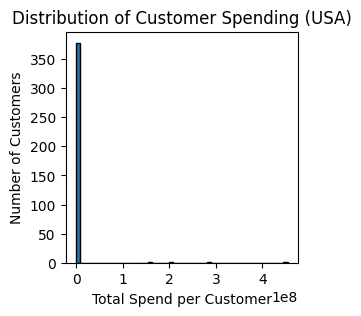

In [36]:
user_totals = country_dfs['USA'].groupby('customer_id')['amount'].sum()

plt.figure(figsize=(3, 3))
plt.hist(user_totals, bins=50, edgecolor='black')
plt.xlabel('Total Spend per Customer')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Spending (USA)')
plt.show()

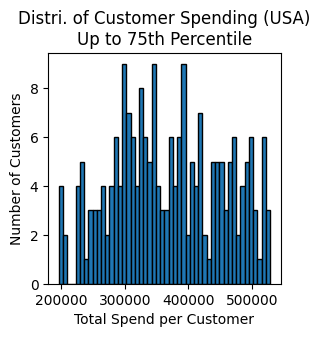

In [44]:
user_totals = country_dfs['USA'].groupby('customer_id')['amount'].sum()

# Calculate 2.5th and 97.5th percentiles
lower_bound = user_totals.quantile(0.00)
upper_bound = user_totals.quantile(0.75)

# Filter to keep only values within this range
filtered_totals = user_totals[(user_totals >= lower_bound) & (user_totals <= upper_bound)]

# Plot the distribution
plt.figure(figsize=(3, 3))
plt.hist(filtered_totals, bins=50, edgecolor='black')
plt.xlabel('Total Spend per Customer')
plt.ylabel('Number of Customers')
plt.title(f'Distri. of Customer Spending (USA)\nUp to 75th Percentile')
plt.show();

In [42]:
for country in country_dfs:
    customer_totals = country_dfs[country].groupby('customer_id')['amount'].sum()
    percentile_75 = customer_totals.quantile(0.75)

    customers_to_drop = customer_totals[customer_totals > percentile_75].index

    country_dfs[country] = country_dfs[country][~country_dfs[country]['customer_id'].isin(customers_to_drop)]

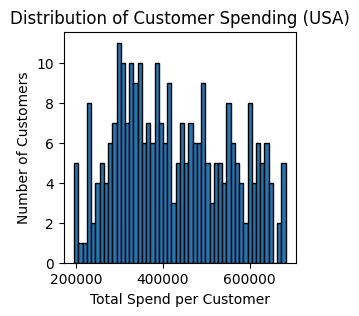

In [43]:
user_totals = country_dfs['USA'].groupby('customer_id')['amount'].sum()

plt.figure(figsize=(3, 3))
plt.hist(user_totals, bins=50, edgecolor='black')
plt.xlabel('Total Spend per Customer')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Spending (USA)')
plt.show()

# JSON

Nested loop to build a JSON-style dictionary

In [45]:
json_dict = {}

for country, df_country in country_dfs.items():
    json_dict[country] = {
        'country_aggregate_data': {
            'Currency': str(df_country['currency'].mode()[0]),
            'Categories': {}
        },
        'users': {}
    }

    for category in df_country['merchant_category'].unique():
        df_cat = df_country[df_country['merchant_category'] == category]

        # num_users = df_cat['customer_id'].nunique()
        total_spent = df_cat['amount'].sum()
        mean_per_single_transaction = df_cat['amount'].mean() if len(df_cat) > 0 else 0

        mean_monthly_total = df_cat.groupby('customer_id')['amount'].sum().mean()  # we need to sum all the transactions
        med_monthly_total = df_cat.groupby('customer_id')['amount'].sum().median()   # within each customerm for their own month total
        std = df_cat.groupby('customer_id')['amount'].sum().std()                  #THEN find the mean, med mode

        json_dict[country]['country_aggregate_data']['Categories'][category] = {
            'total_spent': total_spent,
            'mean_per_single_transaction': mean_per_single_transaction,
            'median_per_single_transaction': df_cat['amount'].median() if len(df_cat) > 0 else 0,
            'med_monthly_total': med_monthly_total,
            'category_std': std,
            'avg_spending_per_user': mean_monthly_total
        }

    for user in df_country['customer_id'].unique():
        customer_data = df_country[df_country['customer_id'] == user]
        total_user_spending = customer_data['amount'].sum()

        json_dict[country]['users'][user] = {
            'total_spending': total_user_spending,
            'categories': {}
        }

        for category in df_country['merchant_category'].unique():

            cat_sub_df = customer_data[customer_data['merchant_category'] == category]

            # national_cat_data = json_dict[country]['country_aggregate_data']['Categories'][category]
            # avg_per_user = national_cat_data['avg_spending_per_user']
            # cat_std = national_cat_data['category_std']

            national_cat_std = json_dict[country]['country_aggregate_data']["Categories"][category]['category_std']
            national_cat_mean = json_dict[country]['country_aggregate_data']["Categories"][category]['avg_spending_per_user']

            if len(cat_sub_df) > 0:
                highest_tx = cat_sub_df.loc[cat_sub_df['amount'].idxmax(), ['amount', 'merchant_type', 'date_transact']].to_dict()
                cat_total = cat_sub_df['amount'].sum()
                #cat_mean = cat_sub_df['amount'].mean()
            else:
                highest_tx = None
                cat_total = 0
                #cat_mean = 0

            # Z-score: handle zero std
            # cat_zscore = (cat_mean - national_cat_data['mean_per_transaction']) / cat_std if cat_std > 0 else 0
            cat_zscore = (cat_total - national_cat_mean) / national_cat_std if national_cat_std > 0 else 0

            # Over benchmark: user total vs average per user
            cat_over_benchmark = bool(cat_total >= 1.5 * national_cat_mean) if national_cat_mean > 0 else False

            json_dict[country]['users'][user]['categories'][category] = {
                'total_cat_spending': cat_total,
                'highest_transaction': highest_tx,
                'cat_zscore': cat_zscore,
                'cat_over_benchmark': cat_over_benchmark
            }

### JSON (one country preview)



In [ ]:
def limit_depth(obj, max_depth, current_depth=0):
    """Recursively limit the depth of nested structures"""
    if current_depth >= max_depth:
        return "..." if isinstance(obj, (dict, list)) else obj

    if isinstance(obj, dict):
        return {k: limit_depth(v, max_depth, current_depth + 1)
                for k, v in list(obj.items())[:7]}  # limit to 7 items
    elif isinstance(obj, list):
        return [limit_depth(item, max_depth, current_depth + 1)
                for item in obj[:7]]  # Limit to 7 items
    else:
        return obj

# Show structure with limited depth
preview = limit_depth(json_dict['USA'], max_depth=6)
print(json.dumps(preview, indent=2))

## JSON Exporting

In [ ]:
from google.colab import drive

# Mount drive if not already mounted
drive.mount('/content/drive')

# Write directly to file without printing
output_path = '/content/drive/MyDrive/nov_code_jam_outputs/all_countries_user_data.json'
with open(output_path, 'w') as f:
    json.dump(json_dict, f, indent=4)

print(f"Saved to {output_path}")

In [ ]:
countries_to_export = ['Mexico']
subset = {country: json_dict[country] for country in countries_to_export if country in json_dict}

# Write directly to file without printing
output_path = '/content/drive/MyDrive/nov_code_jam_outputs/one_country_preview.json'
with open(output_path, 'w') as f:
    json.dump(subset, f, indent=4)

print(f"Saved to {output_path}")

In [ ]:
countries_to_export = ['Mexico', 'USA', 'Canada']
subset = {country: json_dict[country] for country in countries_to_export if country in json_dict}

# Write directly to file without printing
output_path = '/content/drive/MyDrive/nov_code_jam_outputs/north_america_user_data.json'
with open(output_path, 'w') as f:
    json.dump(subset, f, indent=4)

print(f"Saved to {output_path}")

### Visualization

In [ ]:
def plot_all_visuals(country, user_id, data):
  agg_data = data[country]['country_aggregate_data']
  user_data = data[country]['users'][user_id]

  categories = list(agg_data["Categories"].keys())

  df_compare = pd.DataFrame({
      "category": categories,
      "user_spending": [
          user_data["categories"].get(cat, {}).get("total_cat_spending", 0) for cat in categories
      ],
      "avg_spending": [
           agg_data["Categories"][cat]["avg_spending_per_user"] for cat in categories
      ],
      "over_benchmark": [
            user_data["categories"].get(cat, {}).get("cat_over_benchmark", False) for cat in categories
      ]
  })

  plt.figure(figsize=(12,6))
  plt.bar(df_compare["category"], df_compare["avg_spending"], label="Average User")
  plt.bar(df_compare["category"], df_compare["user_spending"], alpha=0.7, label="User")
  plt.xticks(rotation=45)
  plt.ylabel("Spending")
  plt.title(f"{user_id} in {country}: User vs Average per Category")
  plt.legend()
  plt.show()

  df_outliers = df_compare[df_compare["over_benchmark"] == True]
  if not df_outliers.empty:
      plt.figure(figsize=(10,5))
      plt.bar(df_outliers["category"], df_outliers["user_spending"], color='orange')
      plt.ylabel("Spending")
      plt.title(f"{user_id} — Categories >1.5× Avg")
      plt.show()
  else:
      print(f"No outlier categories for {user_id} in {country}.")

  plt.figure(figsize=(7,7))
  plt.pie(
      df_compare["user_spending"],
      labels=df_compare["category"],
      autopct="%1.1f%%",
      startangle=90
  )
  plt.title(f"{user_id} — Spending Distribution by Category")
  plt.show()

In [ ]:
with open('/content/drive/MyDrive/nov_code_jam_outputs/all_countries_user_data.json') as f:
    data = json.load(f)

# Plot all visuals for a user
plot_all_visuals(country="USA", user_id="CUST_76168", data=data)

In [ ]:
import json

file_path = '/content/drive/MyDrive/nov_code_jam_outputs/all_countries_user_data.json'

with open(file_path, 'r') as f:
    lines = f.readlines()

for i, line in enumerate(lines, start=1):
    line = line.strip()
    if not line:  # skip empty lines
        continue
    try:
        json.loads(line)
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError on line {i}: {e}")
        # optionally show the problematic part
        snippet = line[max(0, e.pos-20):e.pos+20]
        print("Problem snippet:", snippet)
        break
